In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [2]:
df = pd.read_csv('../Kaggle_dataset/ACWI3.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1/2/2013,48.919998,49.070000,48.709999,49.040001,41.957142,2298300
1,1/3/2013,48.810001,49.080002,48.720001,48.830002,41.777470,1567500
2,1/4/2013,48.840000,49.099998,48.750000,49.040001,41.957142,1400200
3,1/7/2013,48.790001,48.889999,48.669998,48.840000,41.786026,1497400
4,1/8/2013,48.709999,48.750000,48.430000,48.599998,41.580692,306300


In [3]:
class Agent:

    LEARNING_RATE = 1e-4
    LAYER_SIZE = 256
    GAMMA = 0.9
    OUTPUT_SIZE = 3

    def __init__(self, state_size, window_size, trend, skip):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.X = tf.placeholder(tf.float32, (None, self.state_size))
        self.REWARDS = tf.placeholder(tf.float32, (None))
        self.ACTIONS = tf.placeholder(tf.int32, (None))
        feed_forward = tf.layers.dense(self.X, self.LAYER_SIZE, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed_forward, self.OUTPUT_SIZE, activation = tf.nn.softmax)
        input_y = tf.one_hot(self.ACTIONS, self.OUTPUT_SIZE)
        loglike = tf.log((input_y * (input_y - self.logits) + (1 - input_y) * (input_y + self.logits)) + 1)
        rewards = tf.tile(tf.reshape(self.REWARDS, (-1,1)), [1, self.OUTPUT_SIZE])
        self.cost = -tf.reduce_mean(loglike * (rewards + 1)) 
        self.optimizer = tf.train.AdamOptimizer(learning_rate = self.LEARNING_RATE).minimize(self.cost)
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
    
    def predict(self, inputs):
        return self.sess.run(self.logits, feed_dict={self.X:inputs})
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])
    
    def discount_rewards(self, r):
        discounted_r = np.zeros_like(r)
        running_add = 0
        for t in reversed(range(0, r.size)):
            running_add = running_add * self.GAMMA + r[t]
            discounted_r[t] = running_add
        return discounted_r
    
    def get_predicted_action(self, sequence):
        prediction = self.predict(np.array(sequence))[0]
        return np.argmax(prediction)
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.get_predicted_action(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
                
                
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
        
    
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            ep_history = []
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.get_predicted_action(state)
                next_state = self.get_state(t + 1)
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= close[t]
                
                elif action == 2 and len(inventory):
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                ep_history.append([state,action,starting_money,next_state])
                state = next_state
            ep_history = np.array(ep_history)
            ep_history[:,2] = self.discount_rewards(ep_history[:,2])
            cost, _ = self.sess.run([self.cost, self.optimizer], feed_dict={self.X:np.vstack(ep_history[:,0]),
                                                    self.REWARDS:ep_history[:,2],
                                                    self.ACTIONS:ep_history[:,1]})
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [4]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
agent = Agent(state_size = window_size,
             window_size = window_size,
             trend = close,
             skip = skip)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


C:\Users\Magda\anaconda3\lib\site-packages\ipykernel_launcher.py:107: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


epoch: 10, total rewards: 101.580048.3, cost: -33191.296875, total money: 10101.580048
epoch: 20, total rewards: 118.120045.3, cost: -33052.421875, total money: 9731.960041
epoch: 30, total rewards: 340.640080.3, cost: -32729.736328, total money: 10108.670078
epoch: 40, total rewards: 518.980083.3, cost: -31059.441406, total money: 9380.040089
epoch: 50, total rewards: 522.840050.3, cost: -31023.148438, total money: 8512.370056
epoch: 60, total rewards: 383.140053.3, cost: -31603.494141, total money: 8955.440056
epoch: 70, total rewards: 212.250000.3, cost: -33474.113281, total money: 9520.510010
epoch: 80, total rewards: 393.039982.3, cost: -30611.466797, total money: 7939.099994
epoch: 90, total rewards: 196.000000.3, cost: -33052.277344, total money: 9733.200004
epoch: 100, total rewards: 313.389965.3, cost: -31635.246094, total money: 9179.789974
epoch: 110, total rewards: 526.489971.3, cost: -29628.580078, total money: 8889.569988
epoch: 120, total rewards: 627.620018.3, cost: -30

In [5]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 10: buy 1 unit at price 49.180000, total balance 9950.820000
day 11: buy 1 unit at price 49.520000, total balance 9901.299999
day 14: buy 1 unit at price 49.650002, total balance 9851.649998
day 16: buy 1 unit at price 50.049999, total balance 9801.599998
day 18, sell 1 unit at price 50.200001, investment 2.074015 %, total balance 9851.799999,
day 19: buy 1 unit at price 50.040001, total balance 9801.759998
day 20: buy 1 unit at price 49.889999, total balance 9751.869999
day 21: buy 1 unit at price 50.340000, total balance 9701.529999
day 23: buy 1 unit at price 49.959999, total balance 9651.570000
day 24, sell 1 unit at price 49.990002, investment 0.949114 %, total balance 9701.560001,
day 25: buy 1 unit at price 49.790001, total balance 9651.770000
day 26, sell 1 unit at price 50.060001, investment 0.825780 %, total balance 9701.830002,
day 27: buy 1 unit at price 49.980000, total balance 9651.850002
day 28: buy 1 unit at price 50.169998, total balance 9601.680004
day 29, sell 1 

day 192, sell 1 unit at price 53.790001, investment 0.260949 %, total balance 9685.840015,
day 193, sell 1 unit at price 53.250000, investment -0.243539 %, total balance 9739.090015,
day 195, sell 1 unit at price 54.430000, investment 0.665805 %, total balance 9793.520016,
day 196: buy 1 unit at price 54.759998, total balance 9738.760017
day 197: buy 1 unit at price 54.930000, total balance 9683.830017
day 198: buy 1 unit at price 54.639999, total balance 9629.190018
day 199: buy 1 unit at price 55.189999, total balance 9574.000019
day 200, sell 1 unit at price 55.720001, investment 1.920620 %, total balance 9629.720020,
day 201, sell 1 unit at price 56.029999, investment 3.110045 %, total balance 9685.750019,
day 203, sell 1 unit at price 56.490002, investment 4.766327 %, total balance 9742.240021,
day 204: buy 1 unit at price 56.060001, total balance 9686.180019
day 205, sell 1 unit at price 56.270000, investment 4.280951 %, total balance 9742.450020,
day 207: buy 1 unit at price 56.

day 467: buy 1 unit at price 59.400002, total balance 9808.350021
day 468, sell 1 unit at price 59.529999, investment 1.189864 %, total balance 9867.880020,
day 470: buy 1 unit at price 59.540001, total balance 9808.340019
day 471: buy 1 unit at price 59.630001, total balance 9748.710018
day 472, sell 1 unit at price 59.709999, investment 0.167755 %, total balance 9808.420017,
day 473, sell 1 unit at price 59.619999, investment 0.607493 %, total balance 9868.040016,
day 474, sell 1 unit at price 60.060001, investment 1.111111 %, total balance 9928.100017,
day 477: buy 1 unit at price 60.439999, total balance 9867.660019
day 478, sell 1 unit at price 60.590000, investment 1.763519 %, total balance 9928.250019,
day 480: buy 1 unit at price 60.799999, total balance 9867.450020
day 481: buy 1 unit at price 60.430000, total balance 9807.020019
day 483: buy 1 unit at price 60.310001, total balance 9746.710018
day 484: buy 1 unit at price 60.470001, total balance 9686.240017
day 485, sell 1 u

day 625, sell 1 unit at price 60.900002, investment -1.216545 %, total balance 9225.000031,
day 626, sell 1 unit at price 59.349998, investment -3.464543 %, total balance 9284.350029,
day 628, sell 1 unit at price 59.810001, investment -2.732152 %, total balance 9344.160030,
day 629, sell 1 unit at price 59.849998, investment -3.623188 %, total balance 9404.010029,
day 631, sell 1 unit at price 59.200001, investment -4.469905 %, total balance 9463.210030,
day 632, sell 1 unit at price 58.000000, investment -6.647354 %, total balance 9521.210030,
day 637, sell 1 unit at price 60.389999, investment -3.822267 %, total balance 9581.600029,
day 638: buy 1 unit at price 60.830002, total balance 9520.770027
day 640: buy 1 unit at price 60.799999, total balance 9459.970028
day 641: buy 1 unit at price 60.650002, total balance 9399.320026
day 642: buy 1 unit at price 60.320000, total balance 9339.000027
day 643: buy 1 unit at price 60.020000, total balance 9278.980026
day 644: buy 1 unit at pri

day 791, sell 1 unit at price 52.049999, investment -7.827168 %, total balance 9329.710030,
day 793: buy 1 unit at price 52.480000, total balance 9277.230030
day 794: buy 1 unit at price 52.200001, total balance 9225.030029
day 796, sell 1 unit at price 53.820000, investment -4.540620 %, total balance 9278.850029,
day 797: buy 1 unit at price 54.220001, total balance 9224.630028
day 798: buy 1 unit at price 54.560001, total balance 9170.070026
day 799, sell 1 unit at price 54.599998, investment -0.510209 %, total balance 9224.670025,
day 800, sell 1 unit at price 54.009998, investment -0.074007 %, total balance 9278.680023,
day 801: buy 1 unit at price 54.299999, total balance 9224.380024
day 802, sell 1 unit at price 54.270000, investment 2.803560 %, total balance 9278.650024,
day 803: buy 1 unit at price 55.360001, total balance 9223.290024
day 805: buy 1 unit at price 54.880001, total balance 9168.410023
day 806, sell 1 unit at price 55.400002, investment 6.049004 %, total balance 9

day 980, sell 1 unit at price 58.470001, investment -0.864697 %, total balance 9597.470028,
day 981: buy 1 unit at price 58.709999, total balance 9538.760029
day 983: buy 1 unit at price 58.790001, total balance 9479.970028
day 985: buy 1 unit at price 58.720001, total balance 9421.250027
day 986: buy 1 unit at price 58.570000, total balance 9362.680027
day 988: buy 1 unit at price 58.389999, total balance 9304.290028
day 990, sell 1 unit at price 59.110001, investment 0.118563 %, total balance 9363.400028,
day 991, sell 1 unit at price 59.919998, investment 2.690659 %, total balance 9423.320026,
day 993, sell 1 unit at price 60.310001, investment 3.164561 %, total balance 9483.630028,
day 997, sell 1 unit at price 59.959999, investment 5.137647 %, total balance 9543.590027,
day 998: buy 1 unit at price 59.840000, total balance 9483.750027
day 1000: buy 1 unit at price 60.119999, total balance 9423.630028
day 1001: buy 1 unit at price 59.419998, total balance 9364.210030
day 1002, sell

day 1267: buy 1 unit at price 75.199997, total balance 8737.570049
day 1268, sell 1 unit at price 75.070000, investment 6.785201 %, total balance 8812.640049,
day 1271, sell 1 unit at price 75.919998, investment 7.171093 %, total balance 8888.560047,
day 1272, sell 1 unit at price 76.470001, investment 8.483478 %, total balance 8965.030048,
day 1274, sell 1 unit at price 76.779999, investment 9.093495 %, total balance 9041.810047,
day 1275, sell 1 unit at price 76.709999, investment 8.777656 %, total balance 9118.520046,
day 1276, sell 1 unit at price 77.540001, investment 9.119059 %, total balance 9196.060047,
day 1278, sell 1 unit at price 76.120003, investment 7.075547 %, total balance 9272.180050,
day 1280: buy 1 unit at price 76.150002, total balance 9196.030048
day 1283: buy 1 unit at price 73.050003, total balance 9122.980045
day 1285: buy 1 unit at price 69.830002, total balance 9053.150043
day 1286: buy 1 unit at price 70.639999, total balance 8982.510044
day 1287: buy 1 unit 

day 1419, sell 1 unit at price 73.169998, investment -0.961017 %, total balance 9414.080051,
day 1420: buy 1 unit at price 73.279999, total balance 9340.800053
day 1421, sell 1 unit at price 72.930000, investment -0.869919 %, total balance 9413.730053,
day 1422, sell 1 unit at price 73.489998, investment 0.190865 %, total balance 9487.220051,
day 1423, sell 1 unit at price 74.199997, investment 1.504786 %, total balance 9561.420048,
day 1424, sell 1 unit at price 74.239998, investment 1.199560 %, total balance 9635.660046,
day 1425, sell 1 unit at price 74.680000, investment 1.577807 %, total balance 9710.340046,
day 1426: buy 1 unit at price 74.040001, total balance 9636.300045
day 1427: buy 1 unit at price 73.809998, total balance 9562.490047
day 1429: buy 1 unit at price 73.000000, total balance 9489.490047
day 1430, sell 1 unit at price 72.739998, investment 0.123877 %, total balance 9562.230045,
day 1431, sell 1 unit at price 72.440002, investment 0.304626 %, total balance 9634.67

day 1600: buy 1 unit at price 71.050003, total balance 9418.490047
day 1601, sell 1 unit at price 71.709999, investment 0.307737 %, total balance 9490.200046,
day 1602, sell 1 unit at price 72.000000, investment 0.418414 %, total balance 9562.200046,
day 1604, sell 1 unit at price 71.989998, investment -1.383565 %, total balance 9634.190044,
day 1605, sell 1 unit at price 71.550003, investment -3.075043 %, total balance 9705.740047,
day 1607, sell 1 unit at price 71.910004, investment -2.994730 %, total balance 9777.650051,
day 1608: buy 1 unit at price 71.099998, total balance 9706.550053
day 1609: buy 1 unit at price 71.489998, total balance 9635.060055
day 1610, sell 1 unit at price 70.879997, investment -4.692760 %, total balance 9705.940052,
day 1611: buy 1 unit at price 70.470001, total balance 9635.470051
day 1612, sell 1 unit at price 70.779999, investment -5.057014 %, total balance 9706.250049,
day 1613, sell 1 unit at price 70.089996, investment -5.206933 %, total balance 977

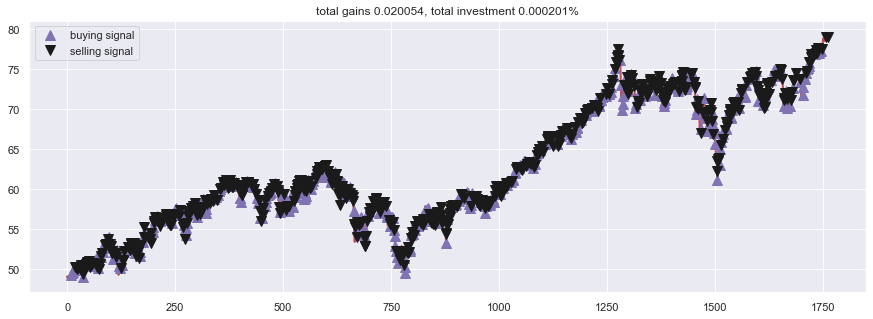

In [6]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()